In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def read_csv(filepath):
    """Auxiliary for reading csv files from project root.
    """
    project_root = '/home/worker/DataScienceMLTest/'
    return pd.read_csv(project_root + filepath)

In [7]:
# Load training data

df_ts = read_csv('training.csv')

# First impressions

The datetime column (i.e., ``date``) suggests us to treat the data as a time series prediction problem (🚨 Spoiler alter: it was a bad idea!).
In such case, we would like to have uniformly sampled timestamps without duplicates.

In [8]:
def clean_df(df):
    """Drops duplicates and applies a daily resample to df.
    
    Warning: Empty dates are forward filled.
    """
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    df = df.drop_duplicates(subset='date')
    df = df.set_index('date').resample('D').asfreq().fillna(method='ffill').reset_index()
    
    return df
    

In [9]:
df_ts = clean_df(df_ts)

Now, let us plot the target column (``target``) along with the rest of the numerical features.

In [10]:
# Define numerical columns.

num_columns = df_ts.select_dtypes(exclude=['object', np.datetime64]).columns.tolist()

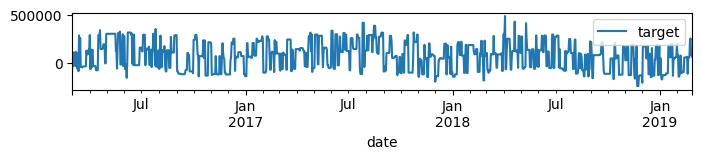

In [ ]:
df_ts.plot(x='date', y='target', figsize=(8, 1))
plt.savefig('target.png', bbox_inches='tight', dpi=100)

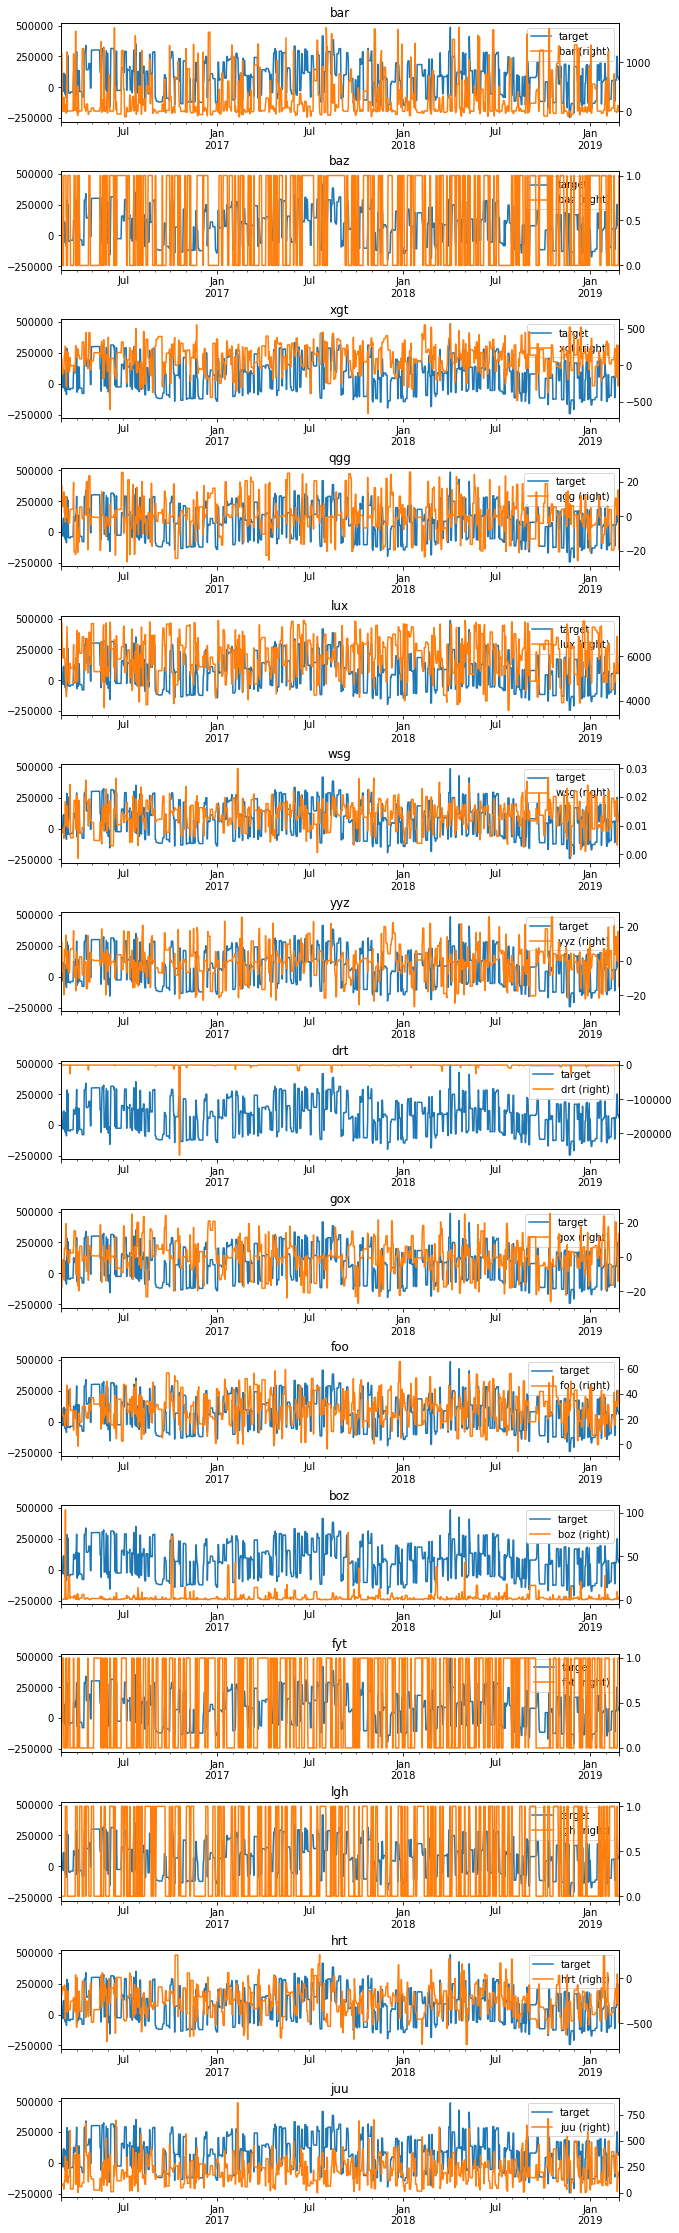

In [7]:
# Plot target vs numerical features.

fig, axs = plt.subplots(len(num_columns) - 1, figsize=(10, 40))
fig.subplots_adjust(hspace=0.5)
for i, col in enumerate(num_columns):
    
    if col == 'target':
        continue
    
    ax = axs[i]    
    df_ts.set_index('date')[['target', col]].plot(secondary_y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

### Observations
* ``target`` slightly shows seasonality within each year. However, there is no visible trend.
* Some features seem to follow ``target``'s seasonality pattern and some others their own.
* There are random fluctuations which do not appear to be very predictable.

# Feature extraction

In [7]:
from tsfresh import extract_features, select_features
from sklearn.pipeline import make_pipeline, Pipeline
from transformers import FeatureExtractor, TimeseriesRoller

In [ ]:
class TimeseriesRoller(BaseEstimator, TransformerMixin):
    """Transforms time series data into sliding sequences.

    Wrapper for tsfresh :pyfunc:`roll_time_series`.

    Parameters
    ----------
    column_id : str
        Column to group by.

    max_timeshift : int
        Maximum window size.

    min_timeshift : int
        Minimum window size.

    column_sort : str
        Datetime column to sort by.
    """

    def __init__(
            self,
            column_id,
            max_timeshift,
            min_timeshift,
            column_sort=None
    ):
        self.column_id = column_id
        self.max_timeshift = max_timeshift
        self.min_timeshift = min_timeshift
        self.column_sort = column_sort

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xt = roll_time_series(
            df_or_dict=X,
            column_id=self.column_id,
            column_sort=self.column_sort,
            max_timeshift=self.max_timeshift,
            min_timeshift=self.min_timeshift,
            **self.kwargs
        )

        if len(X[self.column_id].unique()) == 1:
            Xt[self.column_id] = Xt[self.column_id].map(lambda x: x[1])

        return Xt


class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Extracts time series features.

    Wrapper for tsfresh :pyfunc:`extract_features`.

    Parameters
    ----------
    column_id : str
        Column to group by.

    column_sort : str
        Datetime column to sort by.

    default_fc_parameters : dict, default=MinimalFCParameters()
        Mapping from feature calculator to its parameters.

    """

    def __init__(
            self,
            column_id,
            column_sort,
            default_fc_parameters=MinimalFCParameters()
    ):
        self.column_id = column_id
        self.column_sort = column_sort
        self.default_fc_parameters = default_fc_parameters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return extract_features(
            timeseries_container=X,
            default_fc_parameters=self.default_fc_parameters,
            column_id=self.column_id,
            column_sort=self.column_sort
        )

In [8]:
preprocessor = make_pipeline(
    *[
        TimeseriesRoller(column_id='id', max_timeshift=10, min_timeshift=5, column_sort='date'),
        FeatureExtractor(column_id='id', column_sort='date')
    ]
)


In [9]:
X_train = df_ts[num_columns + ['date']].copy()


In [10]:
X_train.loc[:, 'id'] = 0

In [13]:
X_train_transformed = preprocessor.fit_transform(X_train)

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


# Feature selection

In [14]:
y = df_ts.set_index("date").sort_index()['target'].shift(-1)
y = y[y.index.isin(X_train_transformed.index)].iloc[:-1]
X_train_transformed = X_train_transformed[X_train_transformed.index.isin(y.index)]

In [15]:
X_train_selected = select_features(X_train_transformed, y)

# Gradient boosting  

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [19]:
gb_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor())
    ]
)


In [20]:
gbr = GradientBoostingRegressor().fit(X_train_selected, y)

In [21]:
y_pred = pd.Series(gbr.predict(X_train_selected), index=y.index)

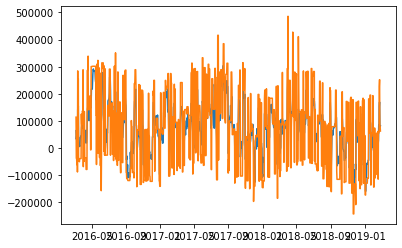

In [22]:
plt.plot(y_pred)
plt.plot(y)

# Predictor

In [204]:
class MultiStepPredictor:
    def __init__(self, roller, preprocessor, estimator, column_id, column_sort, column_target):
        self.roller = roller
        self.preprocessor = preprocessor
        self.estimator = estimator
        self.column_id = column_id
        self.column_sort = column_sort
        self.column_target = column_target
        
        
    def predict(self, X):
        
        X = X.sort_values(self.column_sort)
        X = self.roller.transform(X)
        groupby = X.groupby(self.column_id, sort=False)
        max_timeshift = self.roller.max_timeshift + 1
        y_pred = [self._get_first_output(groupby)]
        
        j = 1
        for name in groupby.groups:
            x = groupby.get_group(name).copy()
            
            # Output values are used as next input at every step
            x.loc[x.index[-j:], self.column_target] = y_pred[-j:]
    
            output = self._transform_predict(x).item()
            y_pred.append(output)
            
            j += 1
            if j > max_timeshift:
                j = max_timeshift
        
        return pd.Series(y_pred[1:], index=list(groupby.groups))
            
    def _transform_predict(self, X):
        cols = ['target__minimum', 'target__maximum', 'target__sum_values',
       'target__mean', 'target__absolute_maximum', 'target__median',
       'target__root_mean_square', 'juu__variance', 'juu__standard_deviation',
       'drt__median', 'wsg__variance', 'wsg__standard_deviation',
       'baz__variance', 'juu__maximum', 'juu__absolute_maximum',
       'wsg__absolute_maximum', 'wsg__maximum', 'boz__absolute_maximum',
       'boz__maximum', 'baz__standard_deviation', 'drt__maximum',
       'lux__minimum']
        X = self.preprocessor.transform(X)
        return self.estimator.predict(X[cols])

        
    def _get_first_output(self, groupby):
        first_group = list(groupby.groups)[0]
        first_output = groupby.get_group(first_group)[self.column_target].iloc[-1]
        
        if np.isnan(first_output):
            raise
        
        return first_output
            
            
            
        
        
        
        
        
        
        

In [205]:
df_ts_test =  pd.read_csv(PROJECT_ROOT + 'test.csv')

In [206]:
df_ts_test = clean_df(df_ts_test)

In [207]:
X_test = df_ts_test[num_columns[:-1] + ['date']].copy()
X_test.loc[:, 'id'] = 0

In [208]:
X_test = pd.concat(
    (
        X_train.loc[X_train['date'].between('2018-03-07', '2018-03-12')],
        X_test
    )
).reset_index(drop=True)

## It was at this point I realize it was a bad idea to treat this task as a time series prediction problem.

In [209]:
msp = MultiStepPredictor(
    roller=roller,
    preprocessor=extractor,
    estimator=gbr,
    column_id='id',
    column_sort='date',
    column_target='target'
)

In [215]:
y_pred_test = msp.predict(X_test.head(10))

Feature Extraction: 100%|██████████| 16/16 [00:00<00:00, 7510.79it/s]


<AxesSubplot:>

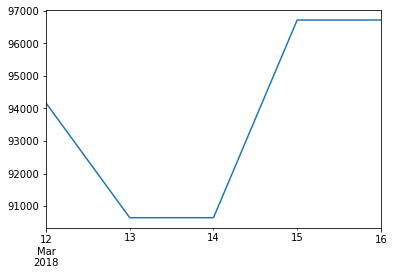

In [216]:
y_pred_test.plot()